##FD schemes convergece investigation using 2D wave equation

In [81]:
%load_ext autoreload
%autoreload 2
from sympy import symbols, init_printing, simplify, solve, srepr, Add, Symbol, Integer, Float, pi, cos, sin, Rational
from sympy import Indexed
from mako.template import Template
from mako.lookup import TemplateLookup
from mako.runtime import Context
from StringIO import StringIO
from fdlib import *
init_printing()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
U,V,Txx,Tyy,Txy = IndexedBases('U V Txx Tyy Txy')
b, lam, mu = symbols('beta lambda mu')
x,y,t,h,dt,a,b, Vs, dimx, dimy = symbols('x y t h dt a b Vs dimx dimy')

In [163]:
accuracy_time = 1 # O(dt^2) accuracy in time domain
accuracy_space = 2 # O(h^4) accuracy in space domain
hf = Rational(1,2) #1/2

###Eigenmode functions (as initial condition and analytical solution)

$U = acos(\pi x)sin(\pi y)cos(at)$<br>
$V = -asin(\pi x)cos(\pi y)cos(at)$<br>
$T_{xx} = -bsin(\pi x)sin(\pi y)sin(at)$<br>
$T_{yy} = bsin(\pi x)sin(\pi y)sin(at)$<br>
$T_{xy} = T_{yx} = 0$<br>
where $a=\sqrt 2 \pi V_s\space \space b=2\pi\mu$

In [4]:
a = 2**(0.5)*pi*Vs
b = 2*pi*mu
U_sol = a*cos(pi*x)*sin(pi*y)*cos(a*t)
V_sol = -a*sin(pi*x)*cos(pi*y)*cos(a*t)
Txx_sol = -b*sin(pi*x)*sin(pi*y)*sin(a*t)
Tyy_sol = b*sin(pi*x)*sin(pi*y)*sin(a*t)
Txy_sol = Float(0)

###Initial conditions

In [5]:
# substitution t=0
U_init = print_myccode(U_sol.subs(t,0))
V_init = print_myccode(V_sol.subs(t,0))
Txx_init = print_myccode(Txx_sol.subs(t,0))
Tyy_init = print_myccode(Tyy_sol.subs(t,0))
Txy_init = print_myccode(Txy_sol.subs(t,0))

###Calculate FD approximation of derivatives

In [6]:
l = [t,x,y]

# first-order time derivatives in velocities and stresses
# O(dt^2) accuracy
DtU = Deriv_half_2(U,l,0,dt,accuracy_time)[1]
DtV = Deriv_half_2(V,l,0,dt,accuracy_time)[1]

DtTxx = Deriv_half_2(Txx,l,0,dt,accuracy_time)[1]
DtTxy = Deriv_half_2(Txy,l,0,dt,accuracy_time)[1]
DtTyy = Deriv_half_2(Tyy,l,0,dt,accuracy_time)[1]

# first-order spacial derivatives of velocities and stresses
# O(h^4) accuracy

DxU = Deriv_half_2(U,l,1,h,accuracy_space)[1]
DyV = Deriv_half_2(V,l,2,h,accuracy_space)[1]

DyU = Deriv_half_2(U,l,2,h,accuracy_space)[1]
DxV = Deriv_half_2(V,l,1,h,accuracy_space)[1]

DxTxx = Deriv_half_2(Txx,l,1,h,accuracy_space)[1]
DyTyy = Deriv_half_2(Tyy,l,2,h,accuracy_space)[1]

DxTxy = Deriv_half_2(Txy,l,1,h,accuracy_space)[1]
DyTxy = Deriv_half_2(Txy,l,2,h,accuracy_space)[1]

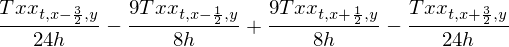

In [7]:
DxTxx

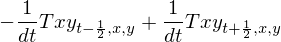

In [8]:
DtTxy

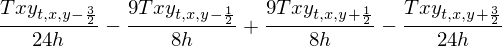

In [9]:
DyTxy

###PDEs

#####momentum equations
$\partial_tU = b(\partial_xT_{xx}+\partial_yT_{xy})$<br>
$\partial_tV = b(\partial_xT_{xy}+\partial_yT_{yy})$<br>
#####stress-strain equations
$\partial_tT_{xx} = (\lambda+2\mu)\partial_xU + \lambda\partial_yV $<br>
$\partial_tT_{yy} = (\lambda+2\mu)\partial_yV + \lambda\partial_xU $<br>
$\partial_tT_{xy} = \mu(\partial_yU + \partial_xV)$<br>

In [10]:
# momentum equations
eq1 = Eq(DtU, b*(DxTxx + DyTxy))
eq2 = Eq(DtV, b*(DxTxy + DyTyy))

# stress-strain equations
eq3 = Eq(DtTxx, (lam + 2*mu)*DxU + lam*DyV)
eq4 = Eq(DtTyy, (lam + 2*mu)*DyV + lam*DxU)
eq5 = Eq(DtTxy, mu*(DyU+DxV))

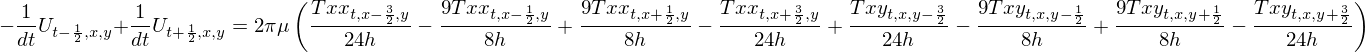

In [11]:
eq1

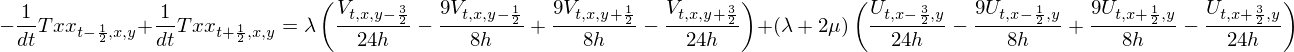

In [12]:
eq3

###solve for FD stencil

In [164]:
# for demo only
# note replacing t-half whith t
U_t = simplify(solve(eq1,U[t+hf,x,y])[0]-U[t-hf,x,y])+U[t,x,y]
V_t = simplify(solve(eq2,V[t+hf,x,y])[0]-V[t-hf,x,y])+V[t-hf,x,y]
Txx_t = simplify(solve(eq3,Txx[t+hf,x,y])[0]-Txx[t-hf,x,y])+Txx[t-hf,x,y]
Tyy_t = simplify(solve(eq4,Tyy[t+hf,x,y])[0]-Tyy[t-hf,x,y])+Tyy[t-hf,x,y]
# note difference between Txx and Txy indices
Txy_t = simplify(solve(eq5,Txy[t+hf,x,y])[0]-Txy[t-hf,x,y])+Txy[t-hf,x,y]

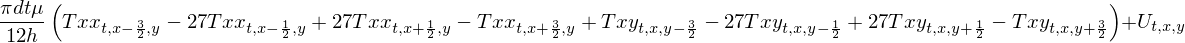

In [165]:
U_t

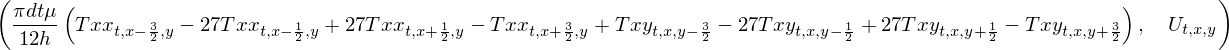

In [166]:
U_t.func(U_t.args)

In [16]:
# generate computation code segments
U_t_code = print_myccode(U[t+1,x,y],pochoir=True) + "=" + print_myccode(U_t,pochoir=True)
V_t_code = print_myccode(V[t+1,x,y],pochoir=True) + "=" + print_myccode(V_t,pochoir=True)
Txx_t_code = print_myccode(Txx[t+1,x,y],pochoir=True) + "=" + print_myccode(Txx_t,pochoir=True)
Tyy_t_code = print_myccode(Tyy[t+1,x,y],pochoir=True) + "=" + print_myccode(Tyy_t,pochoir=True)
Txy_t_code = print_myccode(Txy[t+1,x,y],pochoir=True) + "=" + print_myccode(Txy_t,pochoir=True)

In [17]:
# they look like this
U_t_code

'U(t + 1,x,y)=(1.0/12.0)*M_PI*dt*mu*(Txx(t,x - 3.0/2.0,y) - 27*Txx(t,x - 1.0/2.0,y) + 27*Txx(t,x + 1.0/2.0,y) - Txx(t,x + 3.0/2.0,y) + Txy(t,x,y - 3.0/2.0) - 27*Txy(t,x,y - 1.0/2.0) + 27*Txy(t,x,y + 1.0/2.0) - Txy(t,x,y + 3.0/2.0))/h + U(t,x,y)'

In [18]:
# and this
U_t

##boundary conditions

###get the second order FD approximation in space

In [188]:
l = [t+1,x,y]

# first-order spacial derivatives of velocities
# O(h^2) accuracy
DxU2 = Deriv_half_2(U,l,1,h,1)[1]
DyV2 = Deriv_half_2(V,l,2,h,1)[1]
DyU2 = Deriv_half_2(U,l,2,h,1)[1]
DxV2 = Deriv_half_2(V,l,1,h,1)[1]

# these are used to calculate U and V beyond boundary
Txx_expr = (lam + 2*mu)*DxU2 + lam*DyV2
Tyy_expr = (lam + 2*mu)*DyV2 + lam*DxU2
Txy_expr = mu*(DyU2 + DxV2)

###at boundary $y=2$
$T_{xx}[x,2]=0$<br>
$T_{yy}[x,2]=0$<br>
Txx not needed beyond the boundary<br>
$T_{xx}[x,1]=-T_{xx}[x,3]$<br>
$T_{yy}[x,1]=-T_{yy}[x,3]$<br>
$T_{xy}[x,3/2]=-T_{xy}[x,5/2]$<br>
$T_{xy}[x,1/2]=-T_{xy}[x,7/2]$<br>

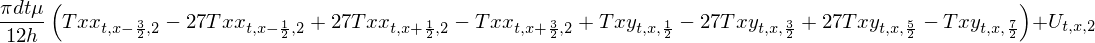

In [168]:
U_t.subs(y,2)

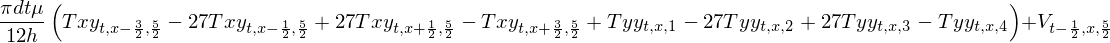

In [169]:
V_t.subs(y,2+hf)

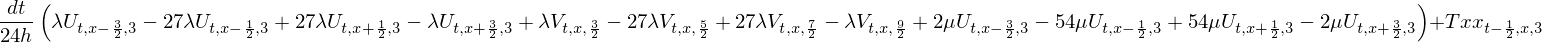

In [170]:
Txx_t.subs(y,3)

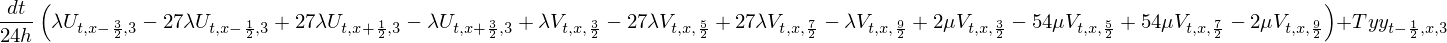

In [171]:
Tyy_t.subs(y,3)

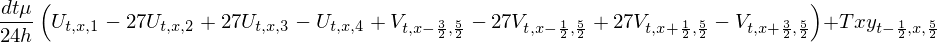

In [174]:
Txy_t.subs(y,2+hf)

###### to calculate above, we need these point beyond the boundary
$T_{xy}[x,\frac{1}{2}] = -T_{xy}[x,\frac{7}{2}]$<br>
$T_{xy}[x,\frac{3}{2}] = -T_{xy}[x,\frac{5}{2}]$<br>
$T_{yy}[x,1] = -T_{yy}[x,3]$<br>
$U[x,1]$<br>
$V[x,\frac{3}{2}]$<br>

####calculate $V[x,\frac{3}{2}]$

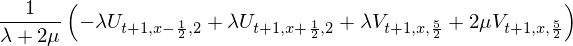

In [190]:
bc_V_y0 = solve(Tyy_expr.subs(y,2), V[t+1,x,1+half])[0]; bc_V_y0

####calculate $U[x,1]$

In [191]:
bc_U_y0 = solve(Eq(Txy_expr.subs({x:x+hf,y:1+half}), -Txy_expr.subs({x:x+hf,y:2+half})),U[t+1,x+hf,1])[0]; bc_U_y0

In [192]:
bc_V_y0_code = print_myccode(shift_grid(bc_V_y0))
bc_U_y0_code = print_myccode(shift_grid(bc_U_y0))

###at boundary $y=dimy+2$
$T_{xx}[x,dimy+2]=0$<br>
$T_{yy}[x,dimy+2]=0$<br>
Txx not needed beyond the boundary<br>
$T_{xx}[x,dimy+1]=-T_{xx}[x,dimy+3]$<br>
$T_{yy}[x,dimy+1]=-T_{yy}[x,dimy+3]$<br>
$T_{xy}[x,dimy+3/2]=-T_{xy}[x,dimy+5/2]$<br>
$T_{xy}[x,dimy+1/2]=-T_{xy}[x,dimy+7/2]$<br>

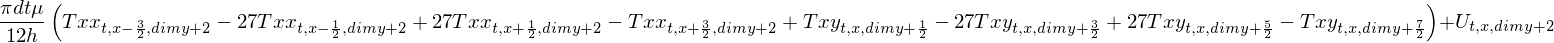

In [35]:
U_t.subs(y,dimy+2)

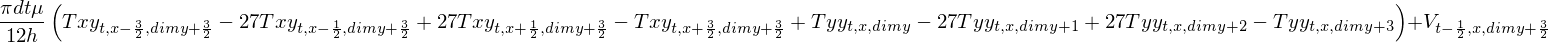

In [36]:
V_t.subs(y,dimy+1+half)

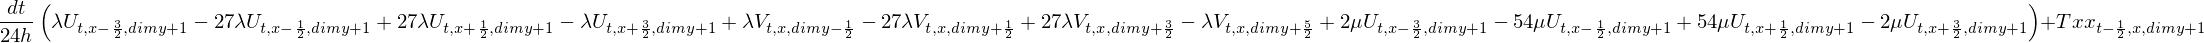

In [37]:
Txx_t.subs(y,dimy+1)

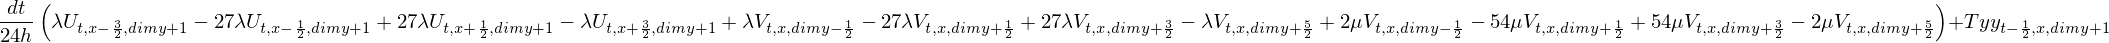

In [38]:
Tyy_t.subs(y,dimy+1)

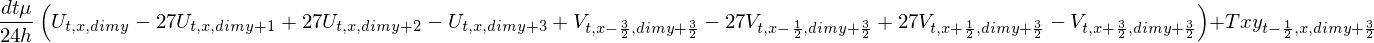

In [39]:
Txy_t.subs(y,dimy+1+half)

###### to calculate above, we need these point beyond the boundary
$T_{xy}[x,dimy+\frac{7}{2}] = -T_{xy}[x,dimy+\frac{1}{2}]$<br>
$T_{xy}[x,\frac{5}{2}] = -T_{xy}[x,\frac{3}{2}]$<br>
$T_{yy}[x,dimy+3] = -T_{yy}[x,dimy+1]$<br>
$U[x,dimy+3]$<br>
$V[x,dimy+\frac{5}{2}]$<br>

####calculate $V[x,dimy+\frac{5}{2}]$

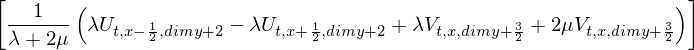

In [40]:
bc_V_y1 = solve(Tyy_expr.subs(y,dimy+2), V[t,x,dimy+2+half]); bc_V_y1

####calculate $U[x+\frac{1}{2},dimy+3]$

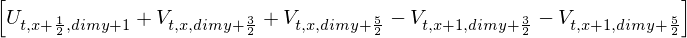

In [161]:
bc_U_y1 = solve(Eq(Txy_expr.subs({x:x+half,y:dimy+2-half}), -Txy_expr.subs({x:x+half,y:dimy+2+half})),U[t,x+half,dimy+3]); bc_U_y1

In [162]:
shift_grid(bc_U_y1[0])

In [153]:
expr.args[3]

In [156]:
shift_grid(expr)

In [138]:
U[x,y].base.label.name

'U'

In [68]:
expr = U[x+1,y+1] + (U[x+half]+U[x+3])*4

In [70]:
expr.func(*expr.args)

In [82]:
isinstance(expr.args[2], Indexed)

True

In [18]:
# constant boundary condition
bc_const = Float(0)
# Dirichlet boundary condition
bc_dirichlet = 100 + 0.2*t
# Neumann boundary condition (expression evaluates to zero)
bc_neumann = Deriv(U,l,1,h,2)[1] - 1

In [19]:
bc_neuman1 = solve(bc_neumann,U[t,x+1,y,z])[0].subs(x+1,x); assign_pochoir_bc(bc_neuman1)

NameError: name 'z' is not defined

In [ ]:
bc_U_x0 = assign_pochoir_bc(bc_const); bc_U_x1 = assign_pochoir_bc(bc_const)
bc_U_y0 = assign_pochoir_bc(bc_const); bc_U_y1 = assign_pochoir_bc(bc_const)

In [ ]:
bc_V_x0 = assign_pochoir_bc(bc_const); bc_V_x1 = assign_pochoir_bc(bc_const)
bc_V_y0 = assign_pochoir_bc(bc_const); bc_V_y1 = assign_pochoir_bc(bc_const)

In [ ]:
bc_Txx_x0 = assign_pochoir_bc(bc_const); bc_Txx_x1 = assign_pochoir_bc(bc_const)
bc_Txx_y0 = assign_pochoir_bc(bc_const); bc_Txx_y1 = assign_pochoir_bc(bc_const)

In [ ]:
bc_Tyy_x0 = assign_pochoir_bc(bc_const); bc_Tyy_x1 = assign_pochoir_bc(bc_const)
bc_Tyy_y0 = assign_pochoir_bc(bc_const); bc_Tyy_y1 = assign_pochoir_bc(bc_const)

In [ ]:
bc_Txy_x0 = assign_pochoir_bc(bc_const); bc_Txy_x1 = assign_pochoir_bc(bc_const)
bc_Txy_y0 = assign_pochoir_bc(bc_const); bc_Txy_y1 = assign_pochoir_bc(bc_const)

###output using templates

In [ ]:
# write to template file
mylookup = TemplateLookup(directories=['templates/'])
mytemplate = mylookup.get_template('test_pochoir_iso_elastic_tmpl.cpp')
buf = StringIO()
dict1 = {'time_period':2,'Txx':Txx_t,'Tyy':Tyy_t,'Tzz':Tzz_t,'Txy':Txy_t,'Txz':Txz_t,'Tyz':Tyz_t,'U':U_t,'V':V_t,'W':W_t}
dict1.update({'bc_U_x0':bc_U_x0,'bc_U_x1':bc_U_x1,'bc_U_y0':bc_U_y0,'bc_U_y1':bc_U_y1,'bc_U_z0':bc_U_z0,'bc_U_z1':bc_U_z1})
dict1.update({'bc_V_x0':bc_V_x0,'bc_V_x1':bc_V_x1,'bc_V_y0':bc_V_y0,'bc_V_y1':bc_V_y1,'bc_V_z0':bc_V_z0,'bc_V_z1':bc_V_z1})
dict1.update({'bc_W_x0':bc_W_x0,'bc_W_x1':bc_W_x1,'bc_W_y0':bc_W_y0,'bc_W_y1':bc_U_y1,'bc_W_z0':bc_W_z0,'bc_W_z1':bc_W_z1})
dict1.update({'bc_Txx_x0':bc_Txx_x0,'bc_Txx_x1':bc_Txx_x1,'bc_Txx_y0':bc_Txx_y0,'bc_Txx_y1':bc_Txx_y1,'bc_Txx_z0':bc_Txx_z0,'bc_Txx_z1':bc_Txx_z1})
dict1.update({'bc_Tyy_x0':bc_Tyy_x0,'bc_Tyy_x1':bc_Tyy_x1,'bc_Tyy_y0':bc_Tyy_y0,'bc_Tyy_y1':bc_Tyy_y1,'bc_Tyy_z0':bc_Tyy_z0,'bc_Tyy_z1':bc_U_z1})
dict1.update({'bc_Tzz_x0':bc_Tzz_x0,'bc_Tzz_x1':bc_Tzz_x1,'bc_Tzz_y0':bc_Tzz_y0,'bc_Tzz_y1':bc_Tzz_y1,'bc_Tzz_z0':bc_Tzz_z0,'bc_Tzz_z1':bc_Tzz_z1})
dict1.update({'bc_Txy_x0':bc_Txy_x0,'bc_Txy_x1':bc_Txy_x1,'bc_Txy_y0':bc_Txy_y0,'bc_Txy_y1':bc_Txy_y1,'bc_Txy_z0':bc_Txy_z0,'bc_Txy_z1':bc_Txy_z1})
dict1.update({'bc_Txz_x0':bc_Txz_x0,'bc_Txz_x1':bc_Txz_x1,'bc_Txz_y0':bc_Txz_y0,'bc_Txz_y1':bc_Txz_y1,'bc_Txz_z0':bc_Txz_z0,'bc_Txz_z1':bc_Txz_z1})
dict1.update({'bc_Tyz_x0':bc_Tyz_x0,'bc_Tyz_x1':bc_Tyz_x1,'bc_Tyz_y0':bc_Tyz_y0,'bc_Tyz_y1':bc_Tyz_y1,'bc_Tyz_z0':bc_Tyz_z0,'bc_Tyz_z1':bc_Tyz_z1})
ctx = Context(buf, **dict1)
mytemplate.render_context(ctx)
code = buf.getvalue()

In [ ]:
# generate compilable C++ source code
f= open('../tests/src/mytest_pochoir.cpp','w')
f.write(code)
f.close()